In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import trange

print(torch.__version__)

1.10.0+cu102


In [2]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부입니다.
cifar10_train = datasets.CIFAR10(root="../Data/", train=True, transform=transform, target_transform=None, download=True)
cifar10_test = datasets.CIFAR10(root="../Data/", train=False, transform=transform, target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(cifar10_train,batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(cifar10_test,batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(len(classes))

10


## Visualizing CIFAR10

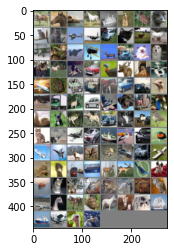

horse horse  ship horse  ship   dog  frog  bird   cat   cat plane plane   car   cat  deer horse plane  frog plane plane  deer truck   cat   dog   cat horse   dog   car  bird  deer   dog plane plane  frog   car truck horse   car   car  bird plane truck  deer   car plane   dog truck  bird   cat   dog  frog   dog   car   cat truck  bird   cat  deer plane   car  ship  bird   car  bird plane plane  deer  deer  frog   car   car plane  bird  bird  ship  ship  deer  deer plane   dog  ship   cat   cat   cat  frog horse  deer   cat plane horse horse  frog   dog horse   cat  ship  ship plane  bird plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## VGGNet(Manual)

## 1) Basic Block

In [8]:
# 컨볼루션 연산이 2번 연속하는 경우
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

  
# 컨볼루션 연산이 3번 연속하는 경우
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

## 2) Define Model & Optimizer & Loss

In [9]:
# 위에서 정의한 블록들을 이용해 VGG 네트워크를 만들어보겠습니다.
# 필터의 개수가 2의 n승의 값을 가지기 때문에 base_dim이란 변수를 추가해서 단순화 했습니다.
# CIFAR10이므로 num_classes=10로 설정했습니다.

class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512        
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로 
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x
    

In [10]:
# gpu가 사용 가능한 경우에는 device를 0번 gpu로 설정하고 불가능하면 cpu로 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 앞서 정의한대로 VGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = VGG(base_dim=64).to(device)

# 손실함수 및 최적화함수를 설정합니다.
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

cuda:0
('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

In [11]:
loss_arr = []
for i in trange(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

  1%|          | 1/100 [00:13<23:03, 13.97s/it]

tensor(1.8975, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 11/100 [02:34<20:49, 14.04s/it]

tensor(0.2754, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 21/100 [04:54<18:29, 14.04s/it]

tensor(0.0597, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 31/100 [07:15<16:09, 14.05s/it]

tensor(0.1581, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 41/100 [09:35<13:48, 14.05s/it]

tensor(0.0065, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 51/100 [11:56<11:28, 14.05s/it]

tensor(0.0296, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 61/100 [14:17<09:07, 14.04s/it]

tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 71/100 [16:37<06:47, 14.04s/it]

tensor(0.0219, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 81/100 [18:57<04:26, 14.04s/it]

tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 91/100 [21:18<02:06, 14.04s/it]

tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 100/100 [23:24<00:00, 14.05s/it]


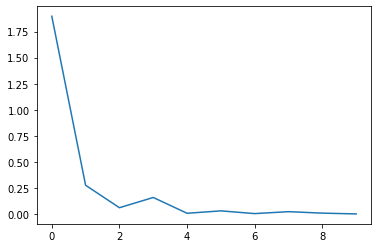

In [12]:
plt.plot(loss_arr)
plt.show()

In [13]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        
        # https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _,output_index = torch.max(output,1)
        #print(len(_), _) #values
        #print(len(output_index), output_index) #indices
        
        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y).sum().float()
    
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 82.33999633789062%
